# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday September 30th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

# Assignment 1.1: Exploring WS and BA models

This first part draws on the Watts-Stogatz and Barabasi-Albert models from Week 3. You should provide solutions to the exercises with the following titles from **Part 1** 

* *Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook*

> *Exercises*: Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook. 
> 
> * What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?\
> Answer: that it predicts that most nodes will have a degree very close to  $\langle k \rangle$, while in the real world the spead is much greater and there are big outliers.\
> * List the four regimes that characterize random networks as a function of $\langle k \rangle$.\
> Answer: Subcritical $\langle k \rangle < 1$, Critical $\langle k \rangle$ = 1, Supercritical $ 1 < \langle k \rangle < ln(N)$, Fully connected $ln(N) < \langle k \rangle$ \
> * According to the book, why is it a problem for random networks (in terms of being a model for real-world networks) that the degree-dependent clustering $C(k)$ decreases as a function of $k$ in real-world networks?\
> Answer: Because the random network model predicts $C(k)$ to be independent of $k$ and only governed by the precondition $p$.

* *WS edition*

> *Exercises*: WS edition.
> 
> * First, let's use `networkx` to play around with WS graphs. Use `nx.watts_strogatz_graph` to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity $p = 0, 0.1,$ and  $1$. Calculate the average shortest path length $\langle d \rangle$ for each one. \
> Answer: p=0 avg(d) = 62.875751503006015, p=0.1 avg(d) = 7.817034068136272, p=1 avg(d) = 4.768064128256513
> * Describe what happens to the network when $p = 1$.\
> Answer: The average distance decreases rapidly at first, then slowly approaches some limit at 1.
> * Generate a lot of networks with different values of $p$. You will notice that paths are short when $p$ is close to one and they are long when $p = 0$. What's the value of $p$ for which the average shortest path length gets close to the short paths we find in a fully randomized network. \
> Answer: It's p = 1. I made two kinds of plot, one regular scale and one log-log, the regular shows decrease in avg(d) with log behaviour that already seems to reach the limit at 0.2, the log-log however shows a new kind of behaviour, the rate of approach following what seems to be an a-curve with it settling around 1 -BOO YAH.
> * Let's investigate this behavior in detail. Generate 50 networks with $N = 500$, $\langle k \rangle = 4$, for each of $p = \{0, 0.01, 0.03, 0.05, 0.1, 0.2\}$. Calculate the average of $\langle d \rangle$ as well as the standard deviation over the 50 networks, to create a plot that shows how the path length decreases very quickly with only a little fraction of re-wiring. Use the standard deviation to add [errorbars](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) to the plot. My version of the plot is below (since a picture's worth 1000 words).\
> Answer: Ah I got a little carried away in the previous one and basically did this. I'll modify it to add error bars and generate it on the linar scale.
> * Imagine that you put this plot in an assignment. Write a figure caption that explains to the reader what the plot shows (which variables, etc) and what's interesting about it.\
> Answer: I'll include both the one asked of me and the log-log plot in this because I also find mine very interesting.

And from **Part 2**

* *BA Edition*.
  * **Note**: The second part of this exercise (after the questions to the text) first has you build a BA network step-by-step, but doesn't ask any questions. For that part, I would simply like you to write well-documented code that shows how you build the network. 


# Assignment 1.2

This second part requires you to have built the network of Rock Musicians as described in the exercises for Week 4. You should complete the following exercise from Part 2.

The code below is for used to solve exercises from part2:

In [1]:
import requests
import re
import networkx as nx

#1. Download the rock_list.txt from GitHub
rock_list_url = "https://raw.githubusercontent.com/Lukog05/Social_Graphs_and_Interactions/main/Assignment1/rock_list.txt"
r = requests.get(rock_list_url)
rock_text = r.text

#2. Extract the Wikipedia page names using regex
wikilink_pattern = r'\[\[([^\]]+)\]\]'
all_wiki_links = re.findall(wikilink_pattern, rock_text)

def clean_title(link):
    # For [[Name|Display]], use Name only
    if '|' in link:
        return link.split('|')[0]
    return link

performer_titles = set(clean_title(link).strip() for link in all_wiki_links)


#3. Generate list of .txt filenames
file_names = [title + ".txt" for title in performer_titles]

#4. Downloading each text file from GitHub and loading content
base_raw_url = "https://raw.githubusercontent.com/Lukog05/Social_Graphs_and_Interactions/main/Assignment1/performer_pages/"

content_dict = {}
for filename in file_names:
    file_url = base_raw_url + filename
    response = requests.get(file_url)
    if response.status_code == 200:
        performer_name = filename[:-4]  # Remove ".txt"
        content_dict[performer_name] = response.text
    elif filename == "AC/DC.txt":
        temp_name = 'AC_DC.txt'
        performer_name = temp_name[:-4]  # Remove ".txt"
        content_dict[performer_name] = response.text
    else:
        print(f"Missing: {filename} ({response.status_code})")

have_titles = set(content_dict.keys())

#5. Building the NetworkX graph (rest unchanged)
G = nx.DiGraph()
for source, content in content_dict.items():
    word_count = len(re.findall(r'\b\w+\b', content))
    G.add_node(source, word_count=word_count)
    outgoing_links = re.findall(r'\[\[([^\]|#]+)', content)
    for target in outgoing_links:
        target_clean = clean_title(target).replace(' ', '_')
        if target_clean in have_titles and target_clean != source:
            G.add_edge(source, target_clean)

#6 Remove isolates and extract largest weakly connected component
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
largest = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest).copy()

# Print useful info
print("Number of nodes in largest component:", G_largest.number_of_nodes())
print("Number of edges in largest component:", G_largest.number_of_edges())
print("Is directed:", G_largest.is_directed())
print("Average degree:", sum(dict(G_largest.degree()).values()) / G_largest.number_of_nodes())
print('\n')
print("Nodes with page:", len(have_titles))
print("All nodes after building network (before prune):", G.number_of_nodes())
print("After removing isolates:", G.number_of_nodes() - len(isolated))
print("Largest component nodes:", G_largest.number_of_nodes())


Number of nodes in largest component: 420
Number of edges in largest component: 1397
Is directed: True
Average degree: 6.652380952380953


Nodes with page: 489
All nodes after building network (before prune): 420
After removing isolates: 351
Largest component nodes: 420


*Excercise*: Explain your process in words

> * Document how you crawled the network.
>    * First, simply describe the steps of the process (what you did, step by step)
>    * Then, write a short section about which part of the process that was most difficult
>    * Next write a short section about how you used LLMs to help you
>    * Finally, compose a short section about what you would do differently if you had to do it again

### Answers
1. 
    First and foremost I downloaded the list of rock performers (source) present in the wikipedia given in the Week4 notebook. Cleaned the text I got and used the API to get download the content in a local directory for each performer. The query I used to do this is similar to the one mentioned in the stack overflow link in Week4 notebook. Also, used a header complying with Wikimedia guidelines in order to access information.

    Now all that's left is to build a Network graph using the NetworkX. Loaded each text file and created a map from performer name to page content. Used a RegEx to extract outgoing wikilinks from the text. Here, you can see a discrepancy (like node and file count difference), because I filtered the links keeping only those that pointed to other rock performers for whom i downloaded the page.

    Node: Performer; Attribute: page word count; Edge: outgoing links between two nodes
    I also extracted the weakly connected component to focus on the densely connected part of network.

2. 
    The hardest part for me was forming the correct RegEx to download the content and also to extract outgoing links and I had to do a lot of trial and error in order to get it right. Also some wiki links have different display names which redirect the page to somewhere other than intended. Furthermore, it took me a while to make sure netwokr has only real nodes (i.e., starting perfomer(node) and linked performer(linked node) had matching pages that I downloaded.)

3. 
    I used LLM in order to aid in solving the hardest parts like I mentioned above about RegEx. I also was stumbled on whether the no.of links i got is true and used LLM to verify it. Also, used it to optmize the query i built initially as it was taking too long to download the pages. Since, I am not that proficient yet in NetworkX I also had to use LLM in order to find functions which met my needs.

4. 
    I would maybe like to implement a way in order to perform error check so that I can find any pages which weren't downloaded or were in a different format(like maybe page can only be downloaded as xml and not json). Also, I would to find a way which checks to make sure performer names are consistent, so that when RegEx is built to download links they aren't missed. I would also love to add onlater a way to record the relationships or nodes which weren't present in the network and why, to help with analysis later on in future.


*Exercise*: Simple network statistics and analysis

> * What is the number of nodes in the network? 
> * More importantly, what is the number of links? (Chat with a fellow student or a TA to make sure you're in the right ball-park)
> * Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?
>     * Compare the out-degree distribution to a *random network* with the same number of nodes and links.
>     * Compare the in-degree distribution to a *scale-free* network with the same number of nodes.
> * Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?
> * What are the 10 pages with the longest wiki entries? (use the `length of content` attribute to figure this one out)?

In [2]:
# Number of nodes (performers)
print("Number of nodes (performers):", G_largest.number_of_nodes())

# Number of links (edges)
print("Number of links:", G_largest.number_of_edges())

Number of nodes (performers): 420
Number of links: 1397


  Using cached matplotlib-3.10.6-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl.metadata (6.4 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached pillow-11.3.0-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
Using cached matplotlib-3.10.6-cp310-cp310-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 32.5 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl (73 kB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
Using cached pillow-11.3.0-cp310-cp310-win_amd64.whl (7.0 MB)

   ---------------------------------------- 0/8 [pyp

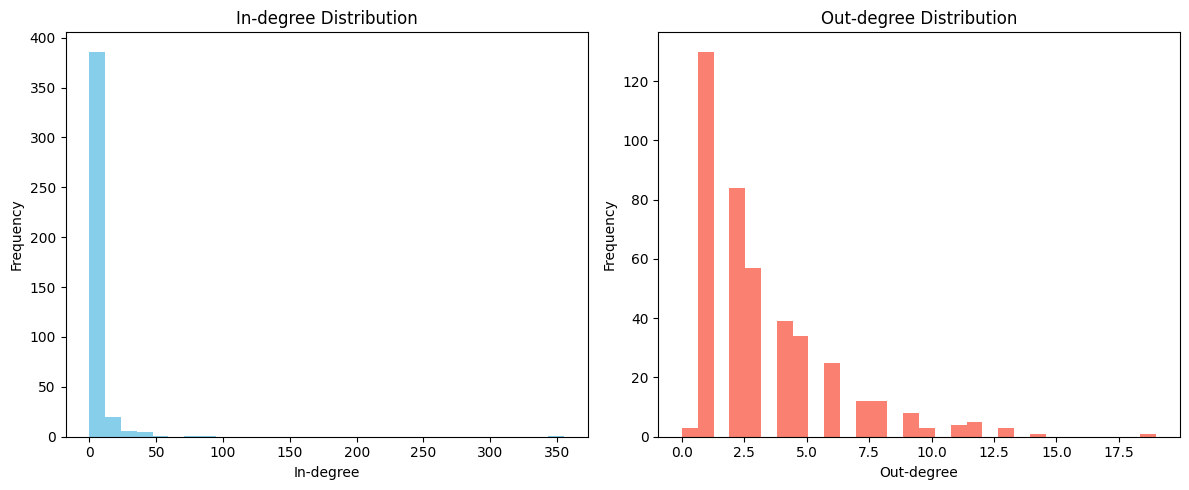

In [ ]:
import matplotlib.pyplot as plt

# In-degree and out-degree lists
in_degrees = [deg for node, deg in G_largest.in_degree()]
out_degrees = [deg for node, deg in G_largest.out_degree()]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=30, color='skyblue')
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.title('In-degree Distribution')

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=30, color='salmon')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.title('Out-degree Distribution')
plt.tight_layout()
plt.show()

In-degree distribution plot
    X -axis: How many incoming links a performer recieves from other pages (how many times they are mentioned)
    Y -axis: Shows the frequency i.e., no.of performers who have that in-degree

Out-degree distribution plot
    X -axis: How many outgoing links a perfomer page makes to others (how many others they reference)
    Y- axis:  Shows the frequency i.e., no.of performers who have that out-degree

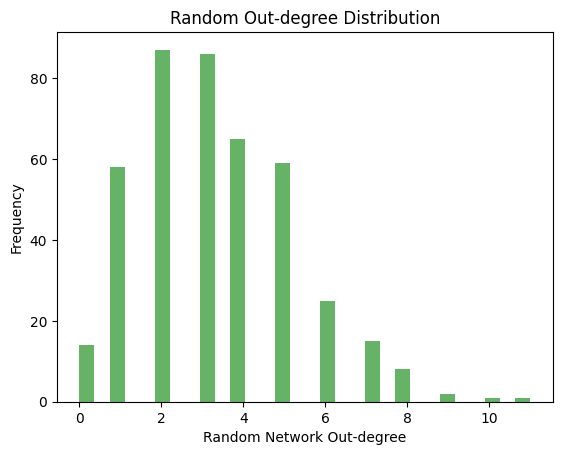

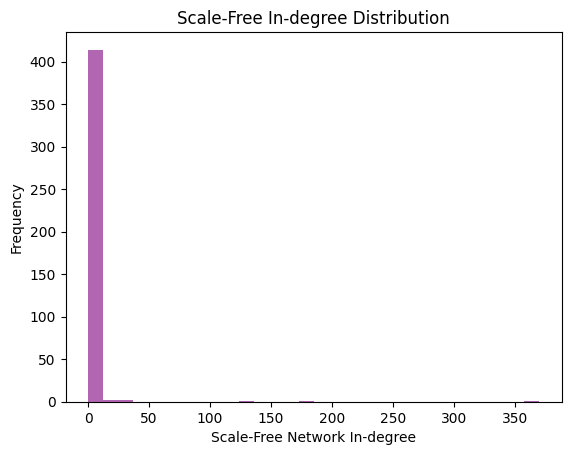

In [14]:
import networkx as nx

# Random network for out-degree comparison
RandG = nx.gnm_random_graph(G_largest.number_of_nodes(), G_largest.number_of_edges(), directed=True)
rand_out_degrees = [deg for node, deg in RandG.out_degree()]

plt.hist(rand_out_degrees, bins=30, color='green', alpha=0.6)
plt.xlabel('Random Network Out-degree')
plt.ylabel('Frequency')
plt.title('Random Out-degree Distribution')
plt.show()

# Scale-free network for in-degree comparison
SF = nx.scale_free_graph(G_largest.number_of_nodes())
sf_in_degrees = [deg for node, deg in SF.in_degree()]
plt.hist(sf_in_degrees, bins=30, color='purple', alpha=0.6)
plt.xlabel('Scale-Free Network In-degree')
plt.ylabel('Frequency')
plt.title('Scale-Free In-degree Distribution')
plt.show()

Random Out degree distribution:
    X -axis: Random Network out degree (how many links each node gives in random network)
    Y -axis: Frequency (how many other out nodes have that out-degree)

Scale Free In degree distribution:
    X -axis: In degree values (how many incoming links a node has)
    Y -axis: Frequency ( how many nodes are there with that in-degree)

In [16]:
# High in-degree performers => most referenced => most famous or acts like a center
top_in = sorted(G_largest.in_degree, key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by in-degree:", top_in)

# High out-degree performers => has links to many others
top_out = sorted(G_largest.out_degree, key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by out-degree:", top_out)


Top 5 by in-degree: [('AllMusic', 355), ('Metallica', 85), ('U2', 73), ('Aerosmith', 48), ('Soundgarden', 46)]
Top 5 by out-degree: [('Alice in Chains', 19), ('Staind', 14), ('Metallica', 13), ('Black Sabbath', 13), ('Limp Bizkit', 13)]


In [ ]:
# Get word count from node attributes
# length of content = word_count
longest_entries = sorted(G_largest.nodes(data='word_count'), key=lambda x: x[1], reverse=True)[:10]
print("10 longest wiki entries:")
for performer, count in longest_entries:
    print(performer, count)

10 longest wiki entries:
Guns N' Roses 60853
Coldplay 47164
Marilyn Manson (band) 46032
Queen (band) 45896
The Rolling Stones 44022
U2 43048
Bob Dylan 42509
David Bowie 42408
Paul McCartney 42403
Elton John 41255


*Exercise:* Let's build a simple visualization of the network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in the following exercises.
>2. Use the NetworkX command `nx.spring_layout` or `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithms here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Set up your plot so that node-size depends on the node *degree*.
>   * Make the node color depend on the `length of content` attribute. I recommend choosing a color scheme that is quite simple (e.g. the Sequential ones here: https://matplotlib.org/stable/users/explain/colors/colormaps.html)

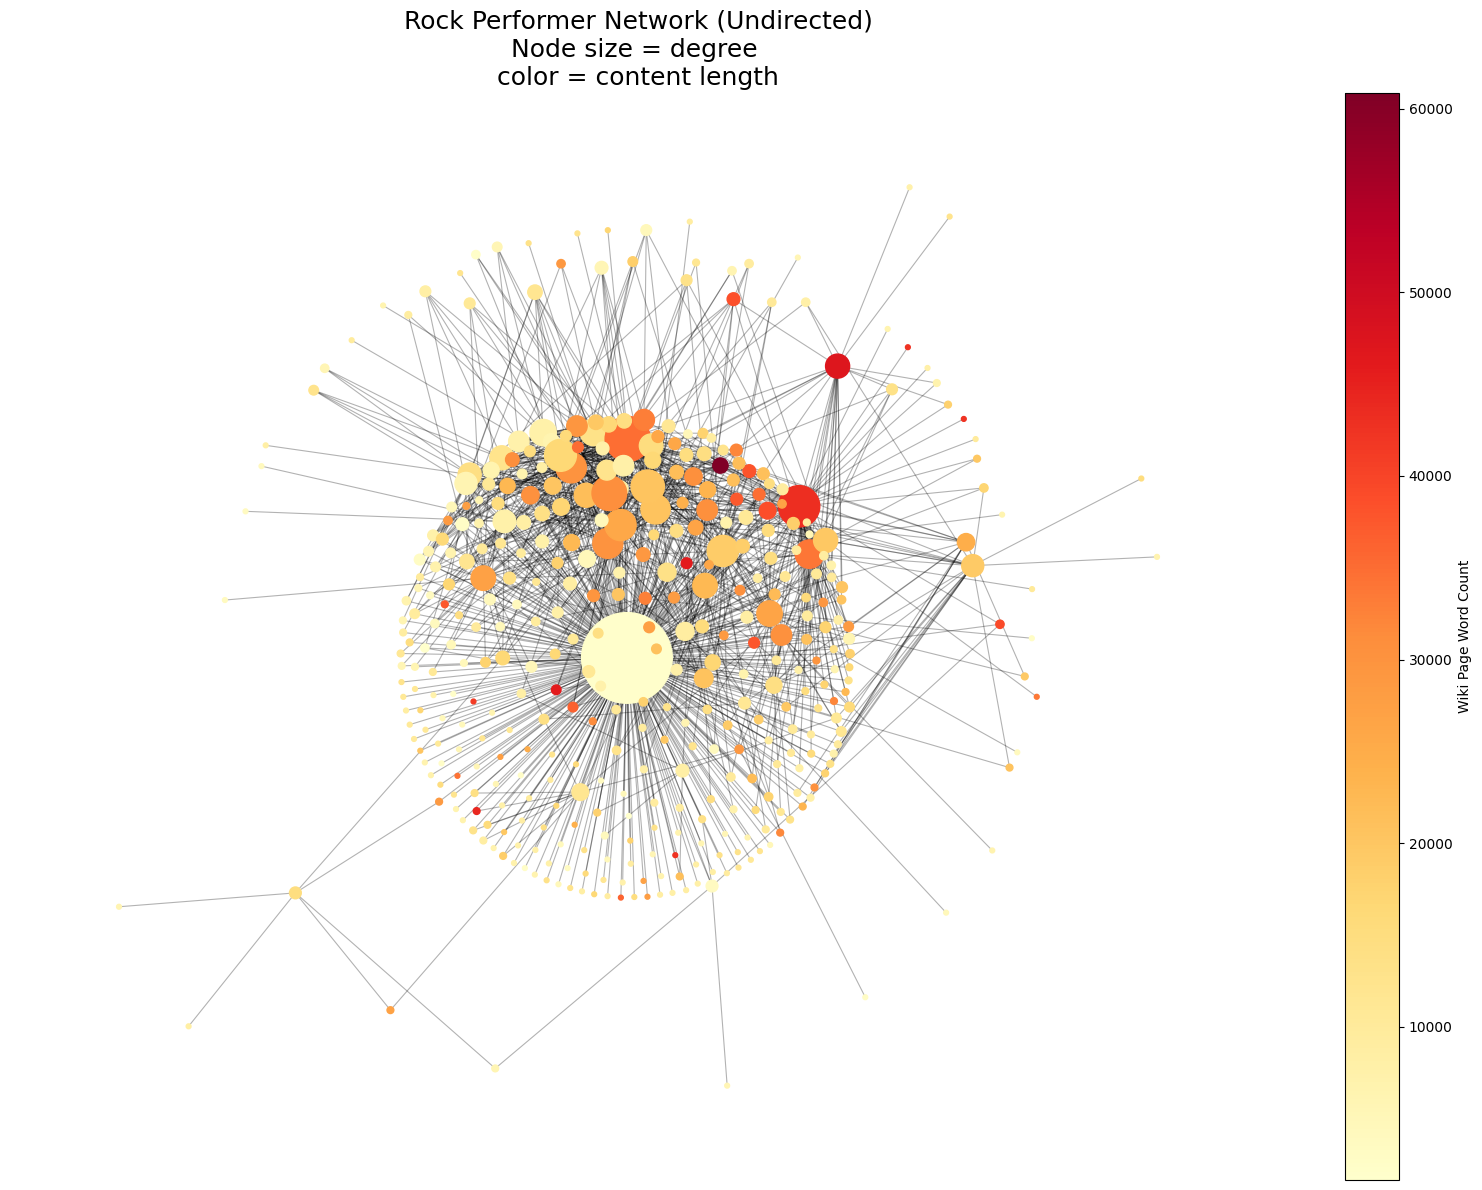

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Assume G_largest is your directed graph (from previous work)

# 1. Convert to undirected graph for visualization
G_undirected = G_largest.to_undirected()

# 2. Compute node sizes and colors
degrees = dict(G_undirected.degree())
node_sizes = [degrees[node] * 12 for node in G_undirected.nodes()]  # Scale factor for visibility

# Node color: length of content (word count attribute)
word_counts = nx.get_node_attributes(G_undirected, 'word_count')
min_wc = min(word_counts.values())
max_wc = max(word_counts.values())
node_colors = [word_counts[node] for node in G_undirected.nodes()]

# 3. Choose layout (spring or kamada-kawai, you can try both)
# pos = nx.spring_layout(G_undirected, seed=42)
pos = nx.kamada_kawai_layout(G_undirected)

# 4. Draw graph
plt.figure(figsize=(16, 12))
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.YlOrRd,  # Sequential colormap
    vmin=min_wc, vmax=max_wc
)
edges = nx.draw_networkx_edges(G_undirected, pos, alpha=0.3, width=0.8)

plt.title("Rock Performer Network (Undirected)\nNode size = degree \ncolor = content length", fontsize=18)
plt.axis('off')
plt.colorbar(nodes, label='Wiki Page Word Count')
plt.tight_layout()
plt.show()


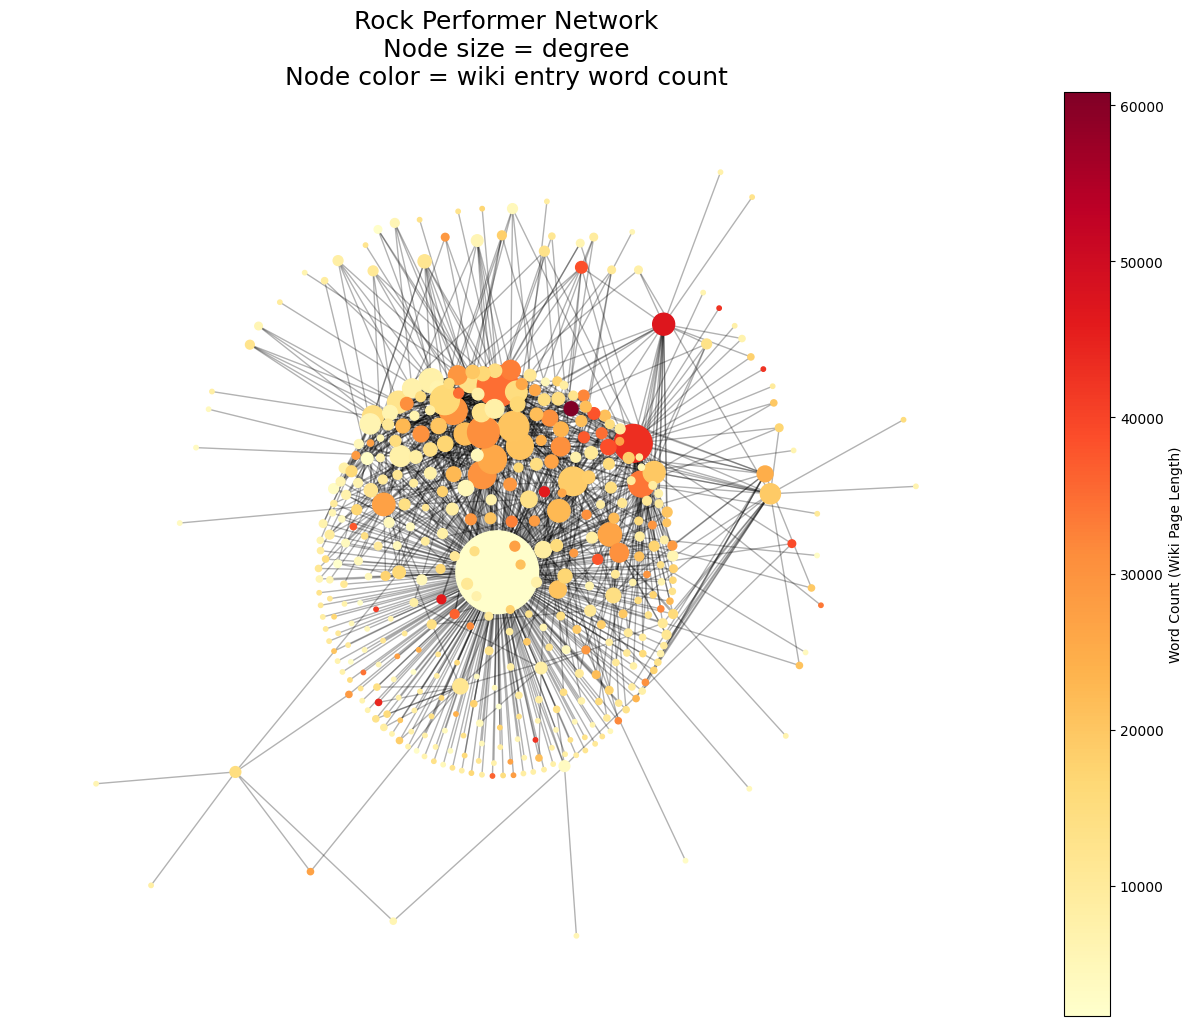

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert the directed graph to undirected (for visualization)
G_undirected = G_largest.to_undirected()

# Node degree (used for node size)
node_degrees = dict(G_undirected.degree())
sizes = [node_degrees[n] * 10 for n in G_undirected.nodes()]  # Scale by 10 for visibility

# Node color: length of content (wiki page word count)
word_counts = nx.get_node_attributes(G_undirected, 'word_count')
colors = [word_counts[n] for n in G_undirected.nodes()]
vmin = min(colors)
vmax = max(colors)

# Choose a force-directed layout (spring or kamada-kawai)
pos = nx.kamada_kawai_layout(G_undirected)
#pos = nx.spring_layout(G_undirected, seed=42)

plt.figure(figsize=(16, 12))
nodes = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=sizes,
    node_color=colors,
    cmap=plt.cm.YlOrRd,  # Sequential colormap
    vmin=vmin, vmax=vmax
)
edges = nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)

plt.title("Rock Performer Network\nNode size = degree\nNode color = wiki entry word count", fontsize=18)
plt.axis('off')
plt.colorbar(nodes, label='Word Count (Wiki Page Length)')
plt.show()

spring_layout: models nodes as repelling each other and edges as spring which hold them together.
kamada_kawai_layout: positions nodes such that display(geometric) distance between them closely matches the shortest path(network) distance.
I used kamada_kawai above and you can see that node that are close in graoh are placed close in the visualization and nodes that are far apart have the visible seperation.